# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Exploratory Data Analysis on the Coffee Quality Institute 2018 Dataset

Submitted by: 
Jan Lendl R. Uy, 2019-00312

### Download the necessary packages

In [1]:
%pip install pandas seaborn matplotlib numpy imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import traceback
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

### Load the dataset as a dataframe

In [3]:
df = pd.read_csv("datasets/merged_data_cleaned.csv")

In [4]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


### Format column names in snake-case

In [5]:
# Function to convert to snake case
def to_snake_case(name):
    # Replace dots and spaces with underscore
    name = name.replace('.', '_').replace(' ', '_')
    # Remove any double underscores
    name = name.replace('__', '_')
    # Convert to lowercase
    return name.lower()

In [6]:
# Get current columns and create a mapping dictionary
column_mapping = {col: to_snake_case(col) for col in df.columns}

# Rename the columns
df = df.rename(columns=column_mapping)

In [7]:
print(df.columns)

Index(['unnamed:_0', 'species', 'owner', 'country_of_origin', 'farm_name',
       'lot_number', 'mill', 'ico_number', 'company', 'altitude', 'region',
       'producer', 'number_of_bags', 'bag_weight', 'in_country_partner',
       'harvest_year', 'grading_date', 'owner_1', 'variety',
       'processing_method', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points',
       'total_cup_points', 'moisture', 'category_one_defects', 'quakers',
       'color', 'category_two_defects', 'expiration', 'certification_body',
       'certification_address', 'certification_contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


### Remove preliminary set of columns not relevant to coffee profiles

In [8]:
columns_to_drop = [
    "owner",
    "owner_1",
    "grading_date",
    "unnamed:_0",  # unnamed index column
    "certification_address", 
    "certification_contact",
    "ico_number",
    "lot_number",
    "expiration",
    "altitude", # No need since this is a range
    "altitude_low_meters", # No need since average is already specified in altitude_mean_meters
    "altitude_high_meters", # No need since average is already specified in altitude_mean_meters
    "in_country_partner",
    "unit_of_measurement"
]

cleaned_df = df.drop(columns_to_drop, axis=1)

In [9]:
print(cleaned_df.columns)

Index(['species', 'country_of_origin', 'farm_name', 'mill', 'company',
       'region', 'producer', 'number_of_bags', 'bag_weight', 'harvest_year',
       'variety', 'processing_method', 'aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness',
       'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects',
       'quakers', 'color', 'category_two_defects', 'certification_body',
       'altitude_mean_meters'],
      dtype='object')


### Remove mean altitudes that are $>8848 m$
This is not possible. Highest elevation above sea level is the peak of Mount Everest, which is at 8,848 meters.

In [10]:
# Print statistics before cleaning
print("Before cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Replace values above 8,848m with NaN
cleaned_df['altitude_mean_meters'] = cleaned_df['altitude_mean_meters'].apply(
    lambda x: np.nan if pd.notnull(x) and x > 8848 else x
)

# Print statistics after cleaning
print("\nAfter cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Show some examples of rows where values were changed
print("\nRows where altitude was set to NaN (showing original altitude_mean_meters):")
mask = cleaned_df['altitude_mean_meters'] > 8848
if len(cleaned_df[mask]) > 0:
    print(cleaned_df[mask][['country_of_origin', 'altitude_mean_meters', 'altitude_mean_meters', 'unit_of_measurement']])
else:
    print("No values were found above 8,848m")

# Basic statistics of the cleaned altitude column
print("\nStatistics of cleaned standardized altitude:")
print(cleaned_df['altitude_mean_meters'].describe())

Before cleaning:
Number of values above 8,848m: 4
Maximum altitude: 190164.0
Total non-null values: 1109

After cleaning:
Number of values above 8,848m: 0
Maximum altitude: 4287.0
Total non-null values: 1105

Rows where altitude was set to NaN (showing original altitude_mean_meters):
No values were found above 8,848m

Statistics of cleaned standardized altitude:
count    1105.000000
mean     1327.765497
std       486.357350
min         1.000000
25%      1100.000000
50%      1310.640000
75%      1600.000000
max      4287.000000
Name: altitude_mean_meters, dtype: float64


## Initial exploratory data analysis

In [11]:
# Basic information about the dataset
print(cleaned_df.info())  # Data types and null values
print(cleaned_df.describe())  # Statistical summary of numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   species               1339 non-null   object 
 1   country_of_origin     1338 non-null   object 
 2   farm_name             980 non-null    object 
 3   mill                  1021 non-null   object 
 4   company               1130 non-null   object 
 5   region                1280 non-null   object 
 6   producer              1107 non-null   object 
 7   number_of_bags        1339 non-null   int64  
 8   bag_weight            1339 non-null   object 
 9   harvest_year          1292 non-null   object 
 10  variety               1113 non-null   object 
 11  processing_method     1169 non-null   object 
 12  aroma                 1339 non-null   float64
 13  flavor                1339 non-null   float64
 14  aftertaste            1339 non-null   float64
 15  acidity              

In [12]:
# Check for missing values
print(cleaned_df.isnull().sum())

species                   0
country_of_origin         1
farm_name               359
mill                    318
company                 209
region                   59
producer                232
number_of_bags            0
bag_weight                0
harvest_year             47
variety                 226
processing_method       170
aroma                     0
flavor                    0
aftertaste                0
acidity                   0
body                      0
balance                   0
uniformity                0
clean_cup                 0
sweetness                 0
cupper_points             0
total_cup_points          0
moisture                  0
category_one_defects      0
quakers                   1
color                   270
category_two_defects      0
certification_body        0
altitude_mean_meters    234
dtype: int64


### Remove row of columns with 1 NaN

In [13]:
cleaned_df = cleaned_df.dropna(subset=["country_of_origin"])  # Drop row with NaN since in country_of_rows there is only 1
cleaned_df = cleaned_df.dropna(subset=["quakers"])  # Drop row with NaN since in quakers there is only 1

### Cupper Points per Region

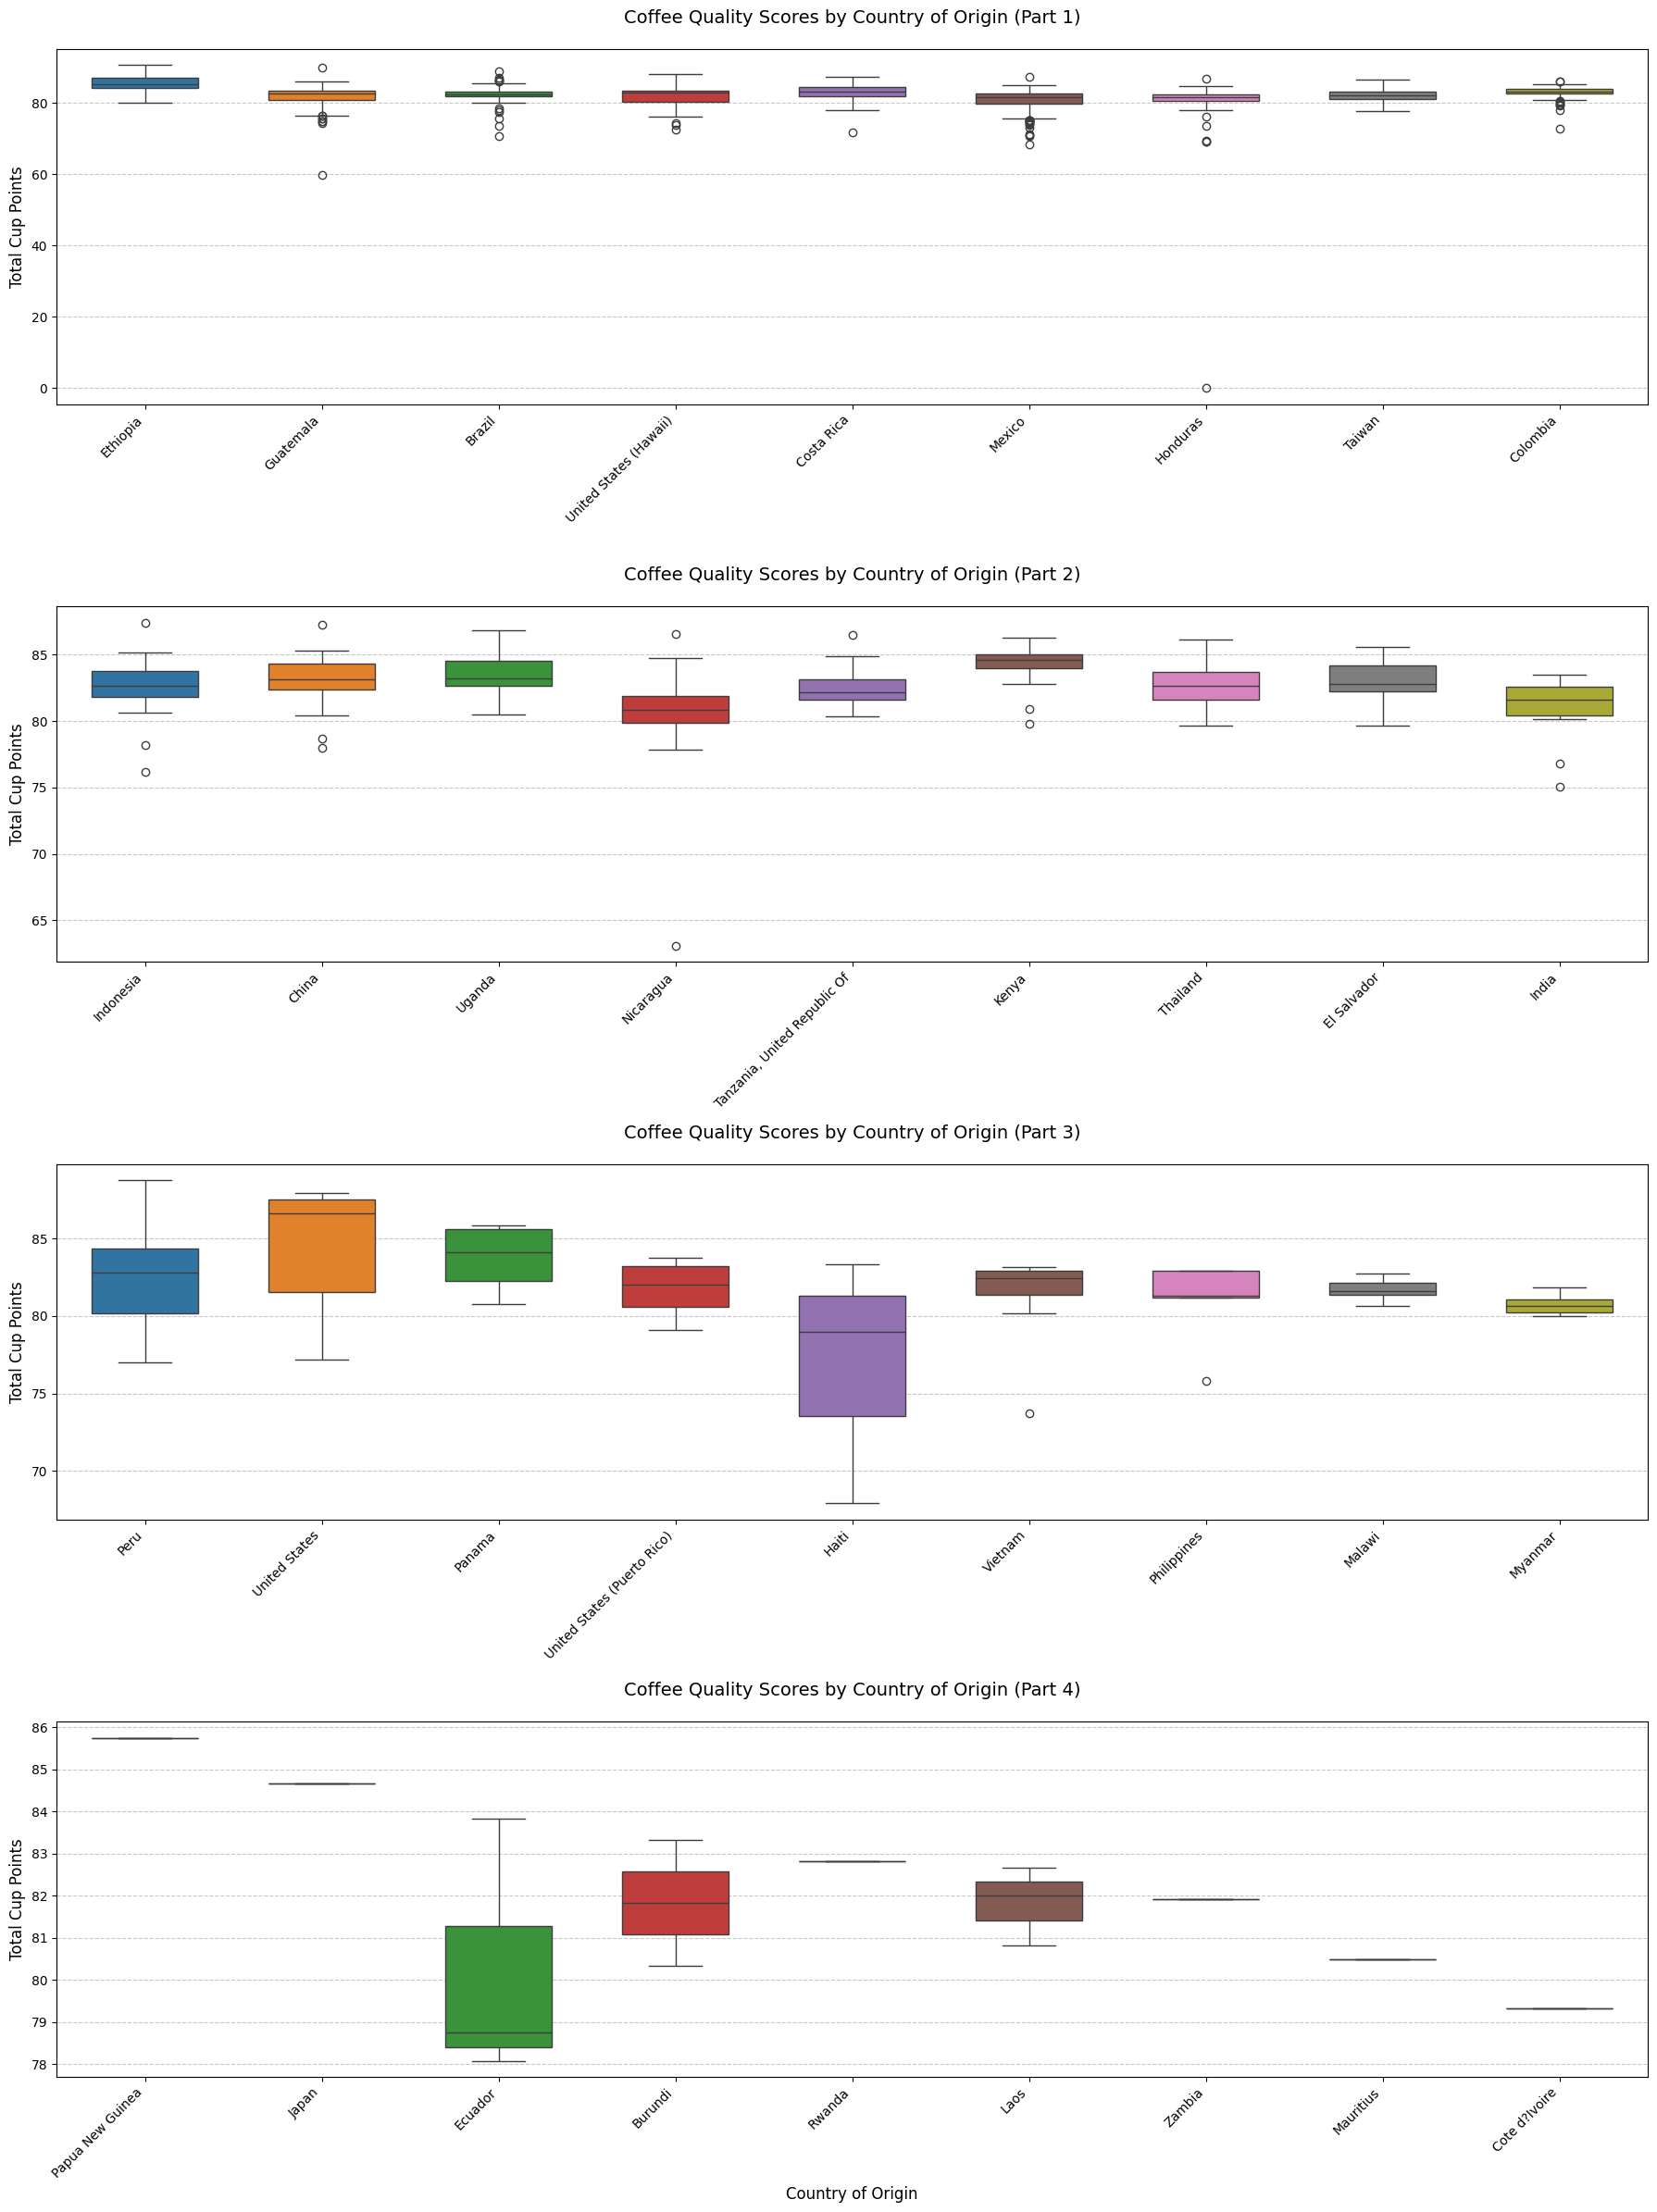


Number of samples per country:
country_of_origin
Mexico                          236
Colombia                        182
Guatemala                       181
Brazil                          132
Taiwan                           75
United States (Hawaii)           73
Honduras                         53
Costa Rica                       51
Ethiopia                         44
Tanzania, United Republic Of     40
Uganda                           36
Thailand                         32
Nicaragua                        26
Kenya                            25
El Salvador                      21
Indonesia                        20
China                            16
India                            14
Malawi                           11
United States                    10
Peru                             10
Myanmar                           8
Vietnam                           8
Haiti                             6
Philippines                       5
United States (Puerto Rico)       4
Panama        

In [14]:
# Get country counts and split into four groups
country_counts = cleaned_df['country_of_origin'].value_counts()
split_point = len(country_counts) // 4
groups = [
   country_counts.index[i*split_point:(i+1)*split_point] 
   for i in range(4)
]

# Create filtered dataframes
dfs = [cleaned_df[cleaned_df['country_of_origin'].isin(group)] for group in groups]

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))

# Plot each group
for i, (df, ax) in enumerate(zip(dfs, axes)):
   sns.boxplot(data=df,
               x='country_of_origin',
               y='total_cup_points', 
               hue='country_of_origin',
               width=0.6,
               ax=ax,
               legend=False)
   
   # Customize plot
   ax.set_title(f'Coffee Quality Scores by Country of Origin (Part {i+1})', 
               pad=20, fontsize=14)
   ax.set_xlabel('' if i < 3 else 'Country of Origin', fontsize=12)
   ax.set_ylabel('Total Cup Points', fontsize=12)
   
   # Fix rotation warning by getting current ticks
   ticks = ax.get_xticks()
   ax.set_xticks(ticks)
   ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
   ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nNumber of samples per country:")
print(country_counts)

### Correlation matrix of coffee taste profiles

Numeric columns: ['number_of_bags', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects', 'quakers', 'category_two_defects', 'altitude_mean_meters']

Categorical columns: ['species', 'country_of_origin', 'farm_name', 'mill', 'company', 'region', 'producer', 'bag_weight', 'harvest_year', 'variety', 'processing_method', 'color', 'certification_body']


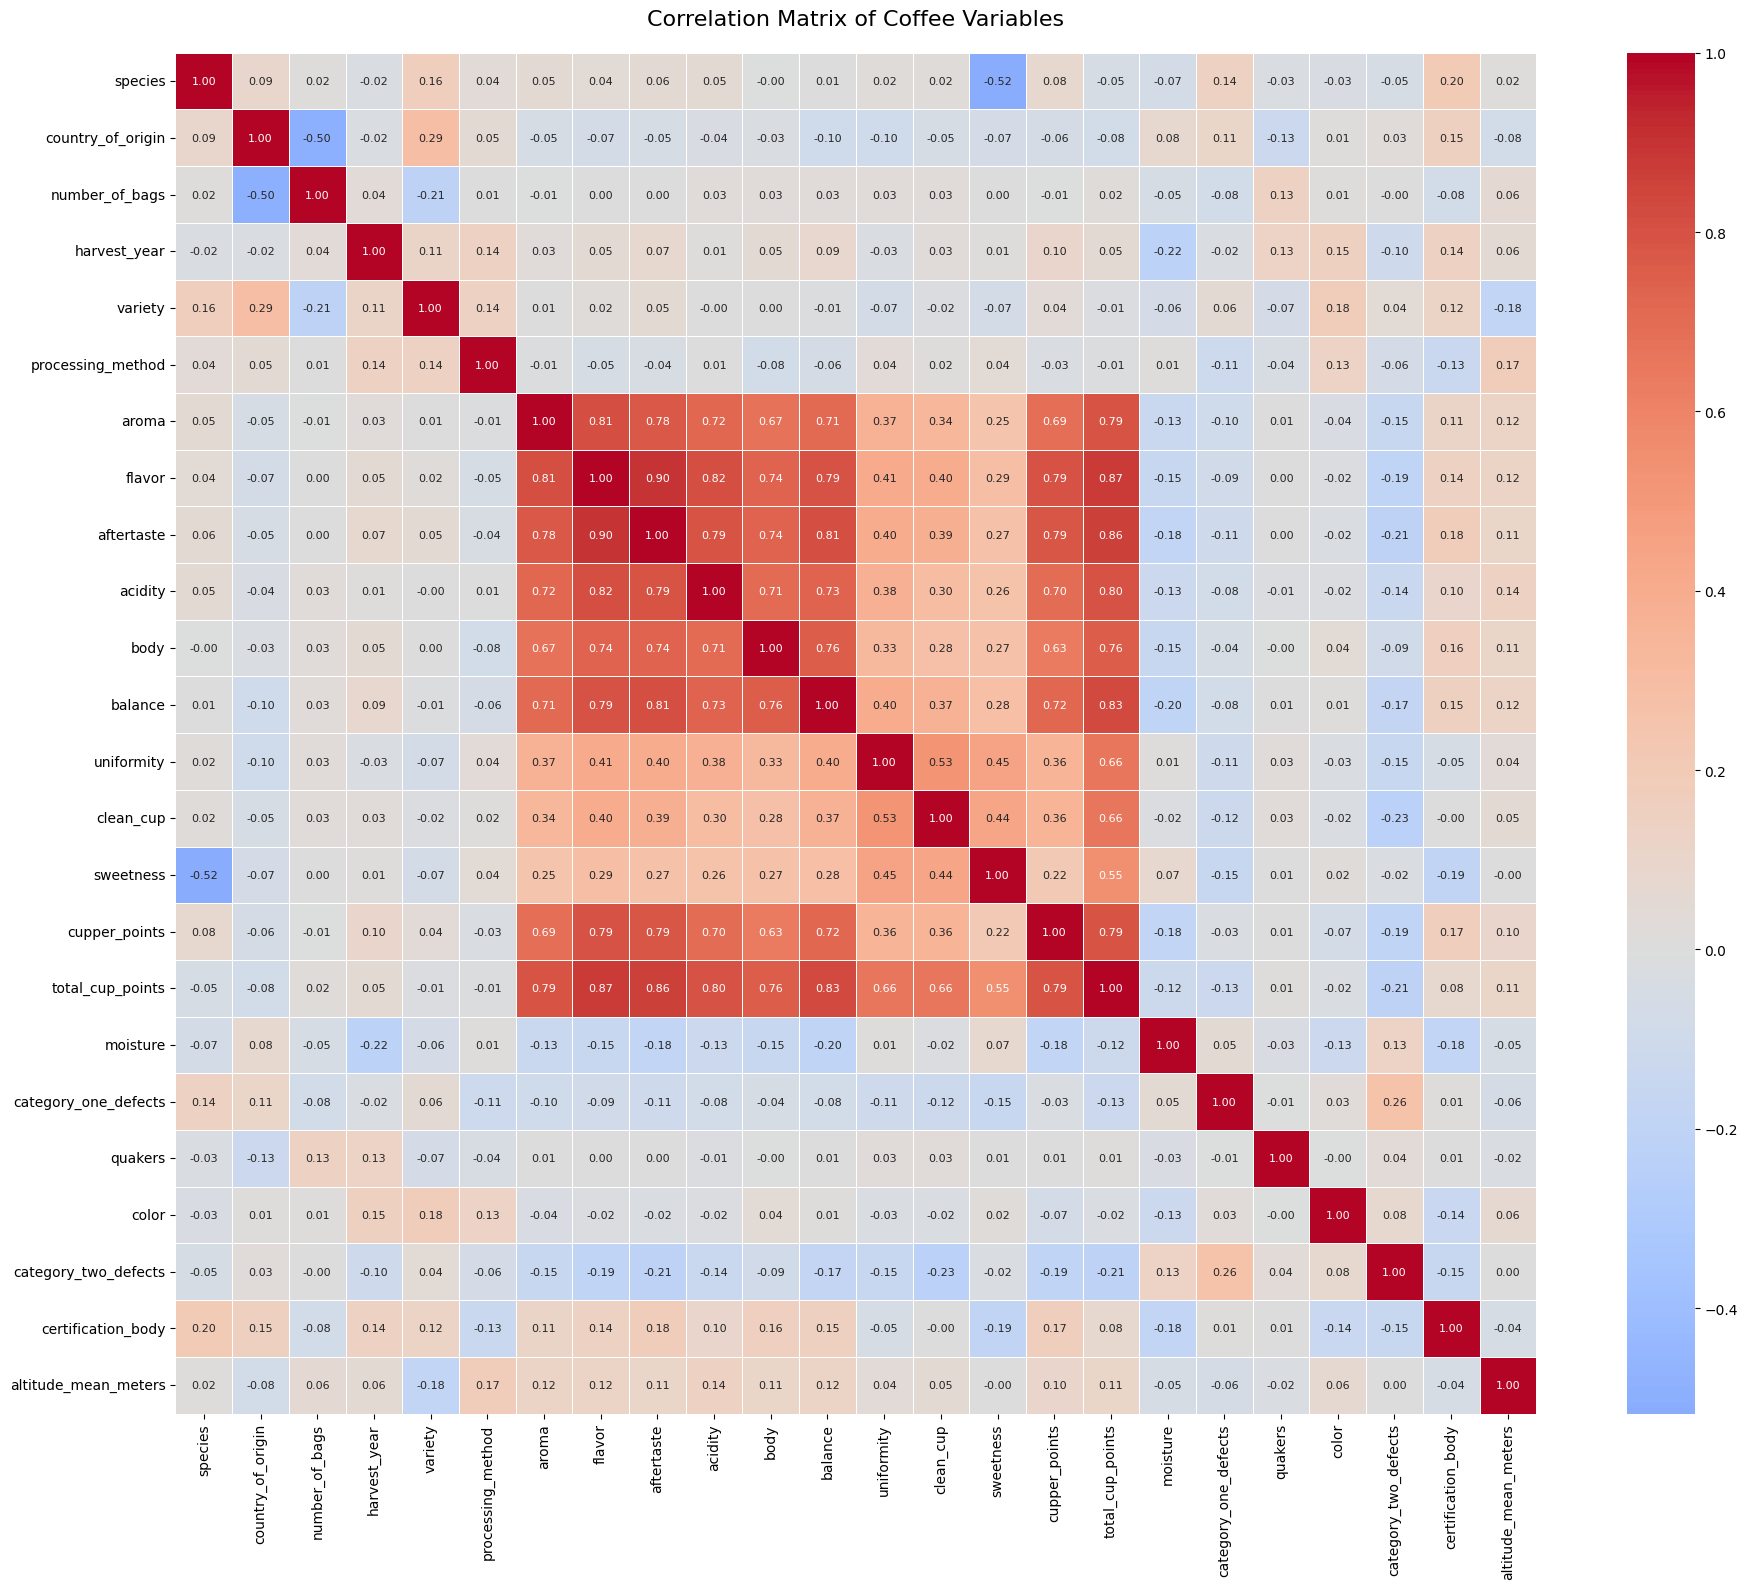


Strongest correlations:
aftertaste        flavor        0.895375
total_cup_points  flavor        0.874487
                  aftertaste    0.861213
                  balance       0.828683
acidity           flavor        0.816178
flavor            aroma         0.812723
balance           aftertaste    0.811316
total_cup_points  acidity       0.797053
cupper_points     flavor        0.793622
balance           flavor        0.793315
dtype: float64


In [15]:
# Create a copy of the dataframe to avoid modifying the original
df_corr = cleaned_df.copy()

# First, identify numeric and categorical columns
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
categorical_cols = df_corr.select_dtypes(include=['object']).columns

print("Numeric columns:", list(numeric_cols))
print("\nCategorical columns:", list(categorical_cols))

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Only encode if the column has less than 50 unique values to avoid too many categories
    if df_corr[col].nunique() < 50:
        df_corr[col] = label_encoder.fit_transform(df_corr[col].astype(str))
    else:
        df_corr = df_corr.drop(columns=[col])

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            square=True,  # Make the plot square-shaped
            fmt='.2f',  # Round correlation values to 2 decimal places
            annot_kws={'size': 8},  # Adjust size of correlation values
            linewidths=0.5)  # Add lines between cells

plt.title('Correlation Matrix of Coffee Variables', pad=20, size=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations
print("\nStrongest correlations:")

# Get the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the correlations and sort by absolute value
strong_correlations = upper.unstack()
strong_correlations = strong_correlations[strong_correlations != 0].sort_values(key=abs, ascending=False)
print(strong_correlations.head(10))

### Altitude versus total cup points

Text(0.5, 1.0, 'Altitude vs Total Cup Points')

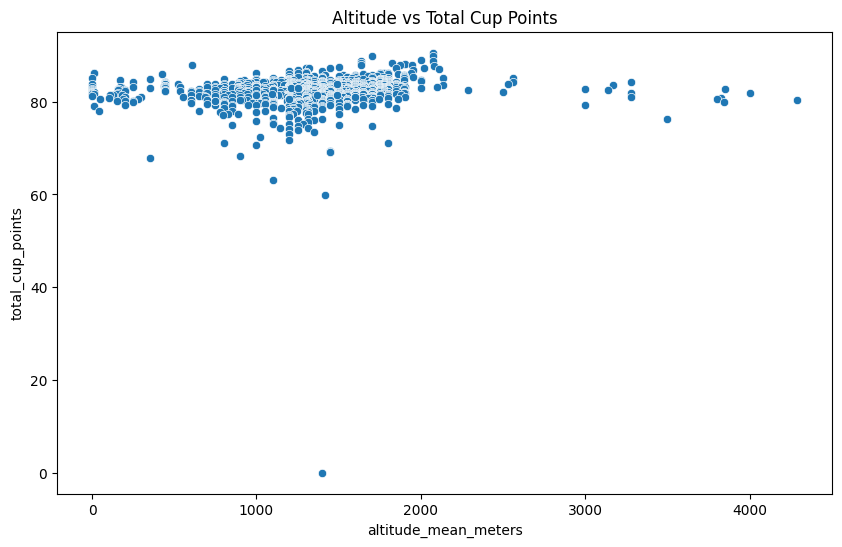

In [16]:
# Analyze relationship between altitude and coffee quality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='altitude_mean_meters', y='total_cup_points')
plt.title('Altitude vs Total Cup Points')

### Quality scores by processing method

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_88740/161456582.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(data=cleaned_df, x='processing_method', y='total_cup_points', hue='processing_method', palette=colors, legend=False)


Text(0.5, 1.0, 'Quality Scores by Processing Method')

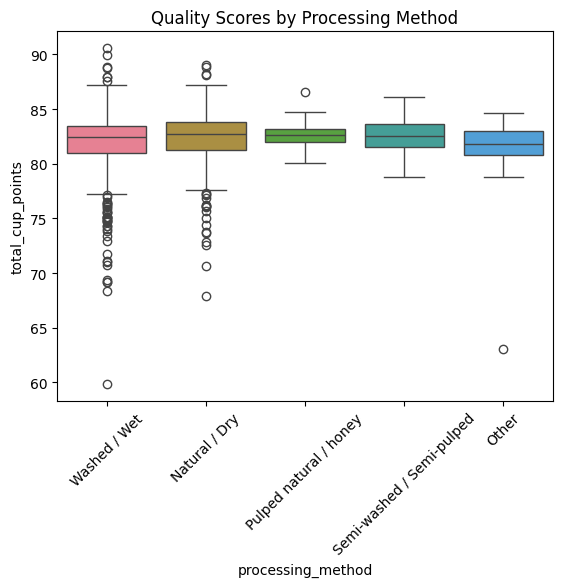

In [17]:
# Get unique processing methods
unique_methods = cleaned_df['processing_method'].unique()
colors = sns.color_palette("husl", len(unique_methods))

sns.boxplot(data=cleaned_df, x='processing_method', y='total_cup_points', hue='processing_method', palette=colors, legend=False)
plt.xticks(rotation=45)
plt.title('Quality Scores by Processing Method')

In [18]:
# Average scores by region
avg_by_region = cleaned_df.groupby('region')['total_cup_points'].mean().sort_values(ascending=False)
print("\nAverage Scores by Region:")
print(avg_by_region)


Average Scores by Region:
region
guji-hambela                       89.776667
snnp/kaffa zone,gimbowereda        88.250000
oromiya                            88.125000
sulawesi                           87.420000
gedio                              87.250000
                                     ...    
marmelade                          72.330000
tlatlauquitepec                    71.080000
sierra norte yajalon, chiapas      70.750000
juchique de ferrer                 68.330000
department d'artibonite , haiti    67.920000
Name: total_cup_points, Length: 356, dtype: float64


### Analyze impacts of category one defects on quality

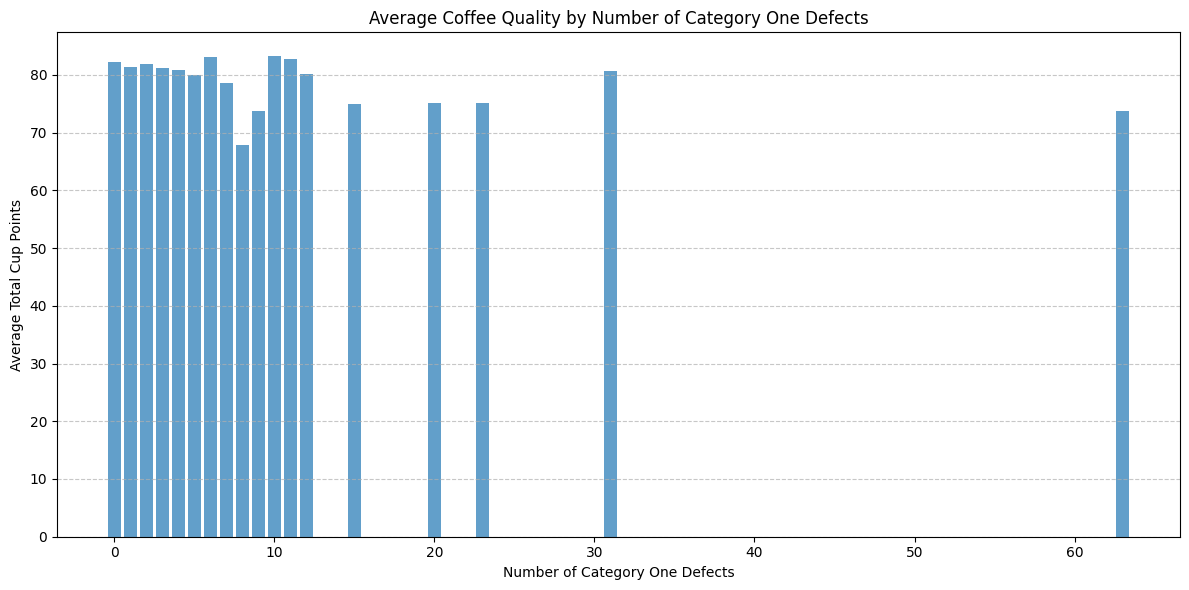

In [19]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_one_defects value
avg_quality = cleaned_df.groupby('category_one_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_one_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category One Defects', fontsize=12)
plt.xlabel('Number of Category One Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Analyze impacts of category two defects on quality

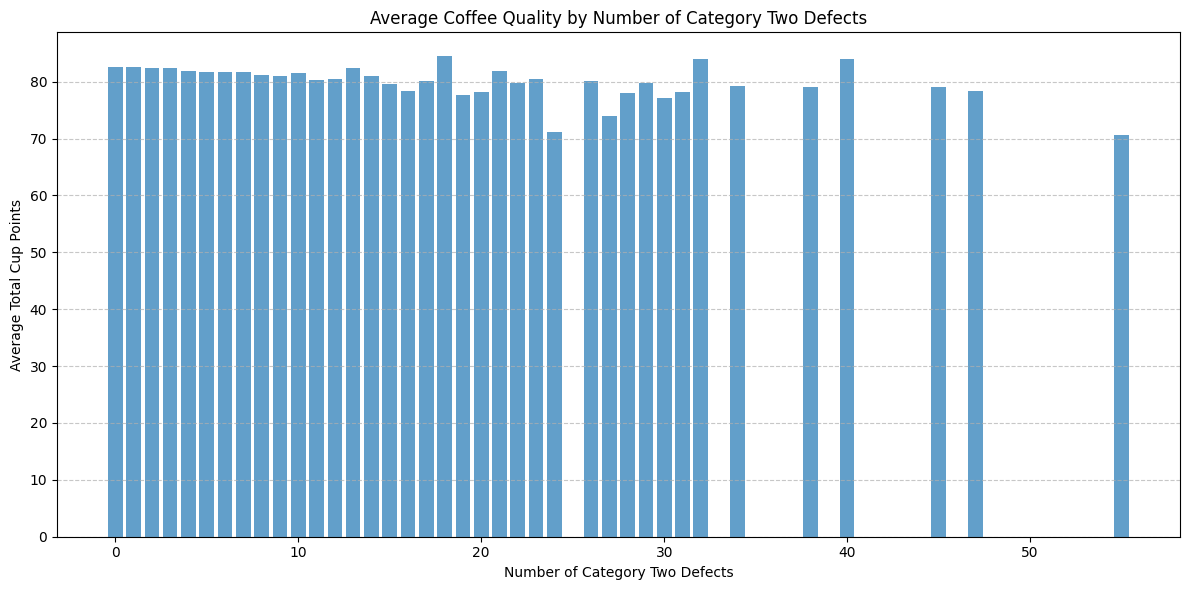

In [20]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_two_defects value
avg_quality = cleaned_df.groupby('category_two_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_two_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category Two Defects', fontsize=12)
plt.xlabel('Number of Category Two Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

## Post-process columns to include in the final dataset

In [21]:
label_cols = ['country_of_origin', 'variety', 'processing_method']
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']

cleaned_df = cleaned_df[feature_cols+label_cols]

### Replace NaN values with the value "Other"
Remove these rows as they are not informative

In [22]:
cleaned_df[['variety', 'processing_method']] = cleaned_df[['variety', 'processing_method']].fillna('Other')
# cleaned_df = cleaned_df[cleaned_df['variety'] != 'Other']
# cleaned_df = cleaned_df[cleaned_df['processing_method'] != 'Other']

### Rename redundantly entitled "United States (Hawaii)" class to just "United States"

In [23]:
# Replace "United States (Hawaii)" with "United States"
cleaned_df['country_of_origin'] = cleaned_df['country_of_origin'].replace('United States (Hawaii)', 'United States')
cleaned_df['country_of_origin'] = cleaned_df['country_of_origin'].replace('United States (Puerto Rico)', 'Puerto Rico')

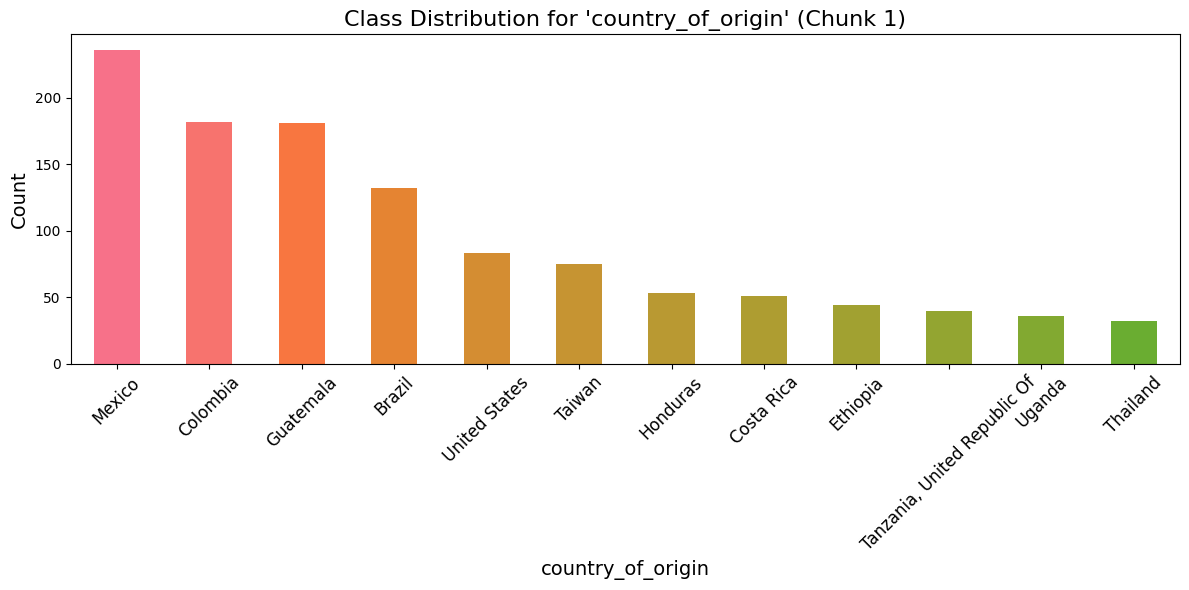

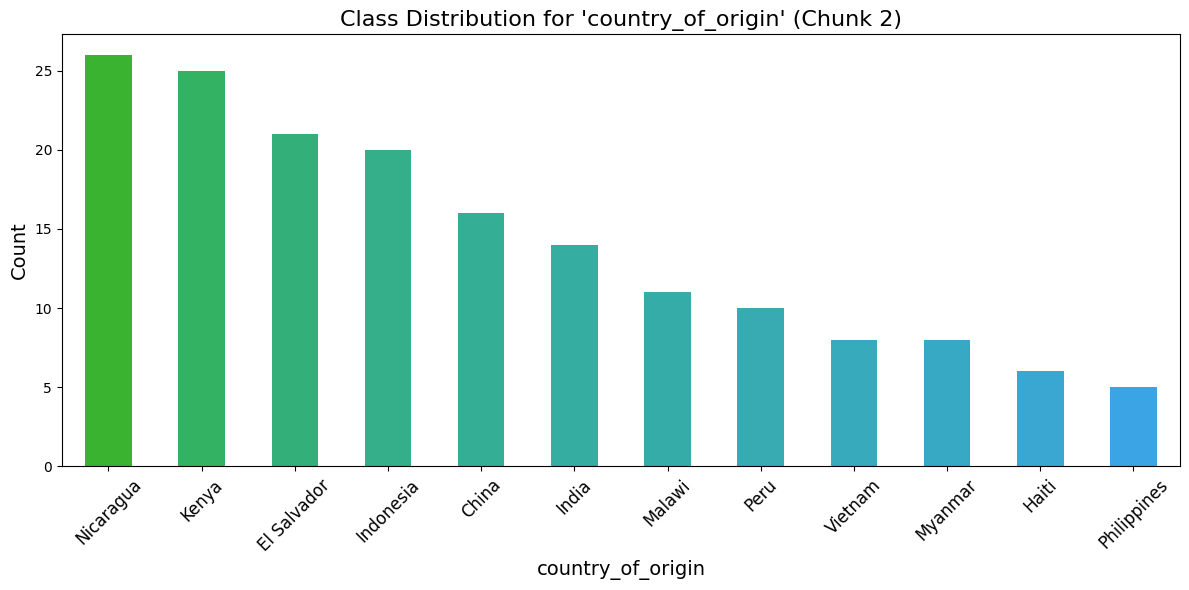

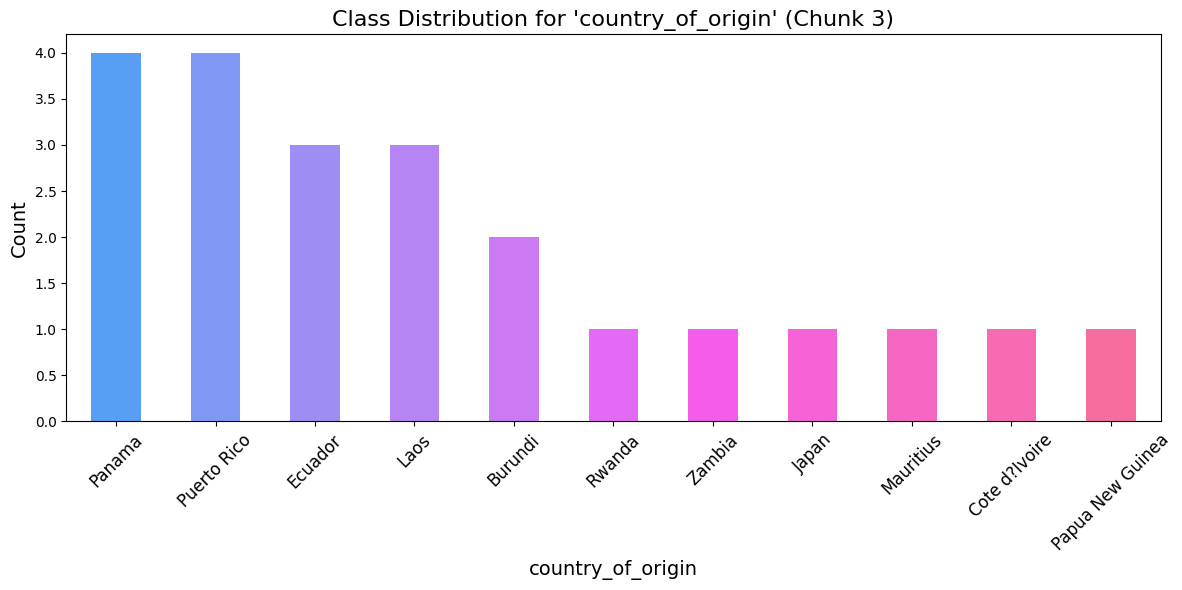

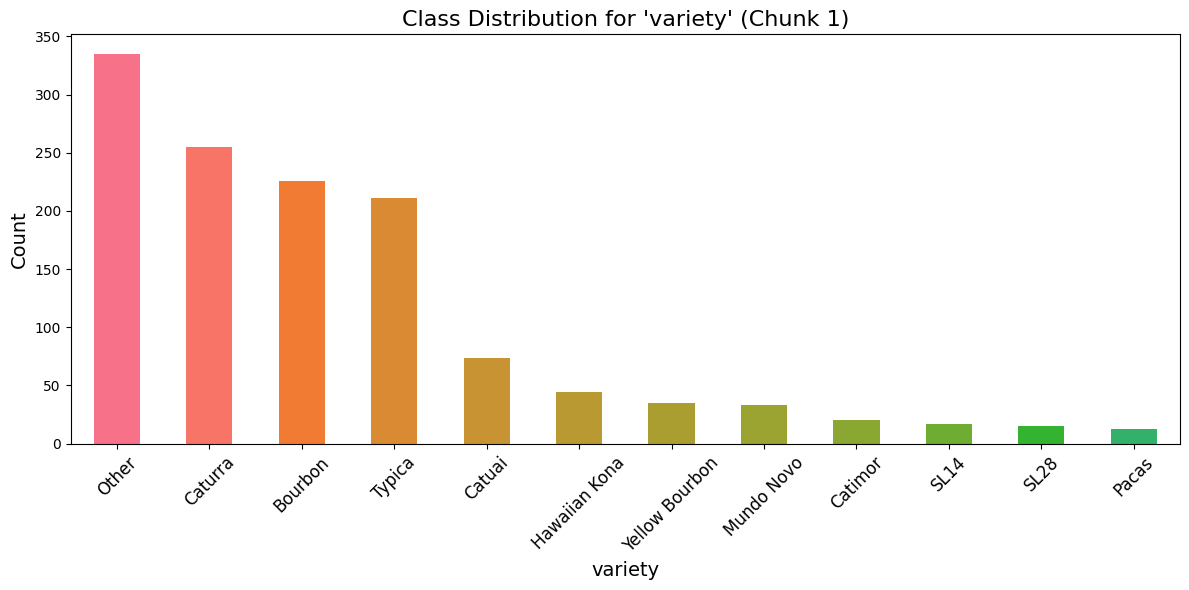

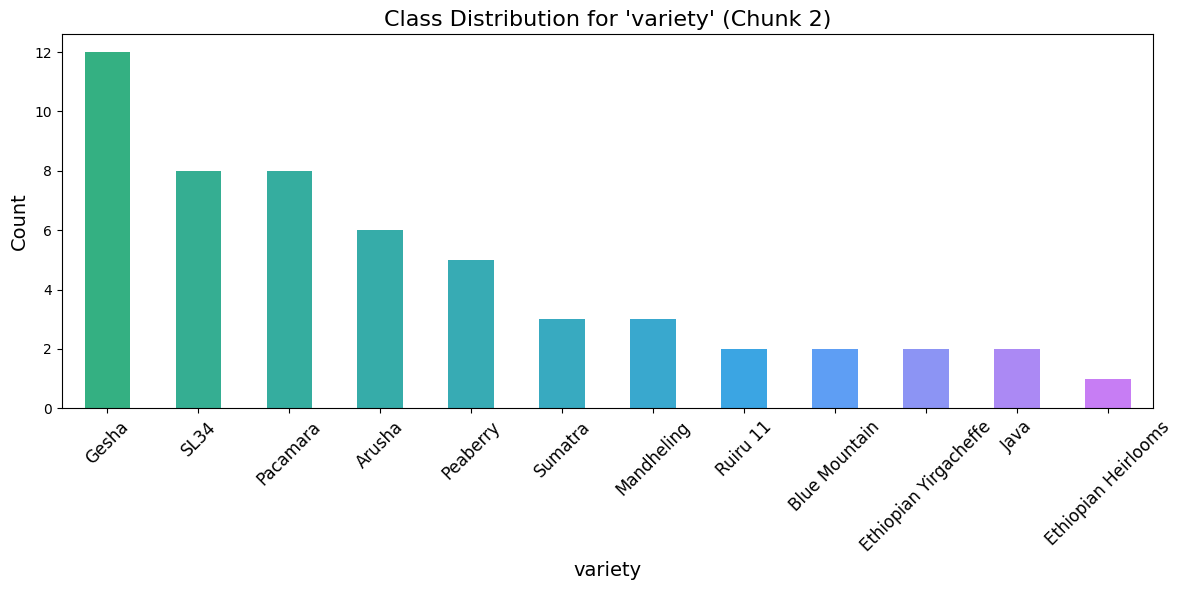

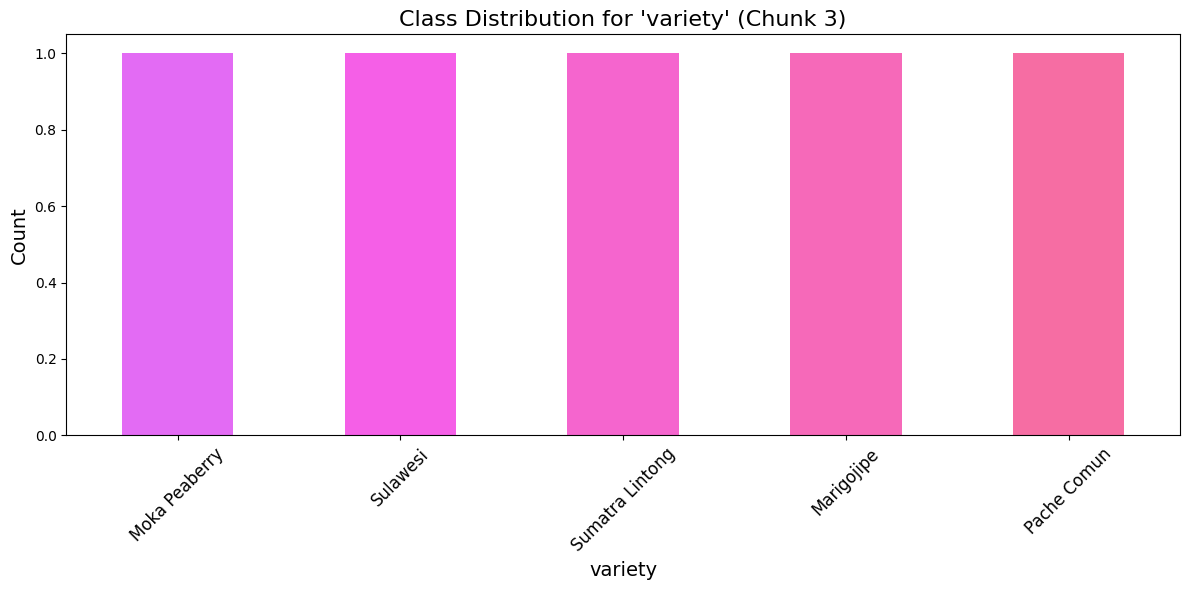

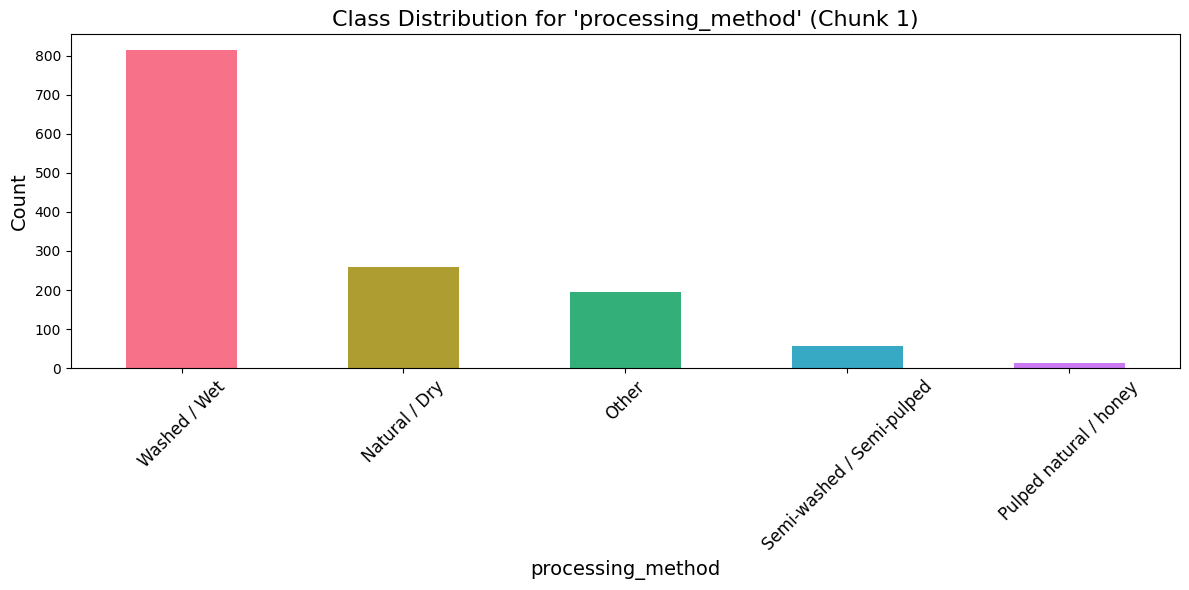

In [24]:
def plot_class_distributions_in_chunks(df, column, chunk_size=12):
    unique_values = df[column].value_counts(dropna=False)
    total_chunks = (len(unique_values) + chunk_size - 1) // chunk_size
    
    # Generate unique colors for each bar
    colors = sns.color_palette("husl", len(unique_values))
    
    for i in range(total_chunks):
        plt.figure(figsize=(12, 6))
        chunk = unique_values[i * chunk_size : (i + 1) * chunk_size]
        chunk_colors = colors[i * chunk_size : (i + 1) * chunk_size]
        chunk.plot(kind='bar', color=chunk_colors)
        plt.title(f"Class Distribution for '{column}' (Chunk {i + 1})", fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

for column in label_cols:
    plot_class_distributions_in_chunks(cleaned_df, column, chunk_size=12)

### Pre-process sparse classes of countries of origin by mapping them to their greater regions

In [ ]:
region_mapping = {
    # Keep major producers (>5%) and 
    # regions with only one country as is
    
    # Central America
    'Honduras': 'Central America',
    'Costa Rica': 'Central America',
    'El Salvador': 'Central America',
    'Nicaragua': 'Central America',
    'Panama': 'Central America',
    
    # East Africa
    'Kenya': 'East Africa',
    'Uganda': 'East Africa',
    'Tanzania, United Republic Of': 'East Africa',
    'Malawi': 'East Africa',
    'Ethiopia': 'East Africa',
    'Rwanda': 'East Africa',
    'Zambia': 'East Africa',
    'Burundi': 'East Africa',
    'Mauritius': 'East Africa',
    
    # Asia Pacific
    'China': 'Asia Pacific',
    'Indonesia': 'Asia Pacific',
    'Thailand': 'Asia Pacific',
    'Myanmar': 'Asia Pacific',
    'Laos': 'Asia Pacific',
    'Vietnam': 'Asia Pacific',
    'Philippines': 'Asia Pacific',
    'Japan': 'Asia Pacific',
    'Papua New Guinea': 'Asia Pacific',
    'India': 'Asia Pacific',
}

# Function to apply the mapping while preserving 
# major producers and regions with only one country
def map_country(country):
    major_producers = {'Mexico', 'Guatemala', 
                      'Colombia', 'Brazil', 
                      'Taiwan', 'United States'}
    return country if country in major_producers else region_mapping.get(country, 'Other')

# Apply the mapping to create a new column
cleaned_df['country_of_origin'] = cleaned_df['country_of_origin'].apply(map_country)

### Get class distributions

In [26]:
def plot_class_distributions_in_chunks(df, column, chunk_size=12):
    unique_values = df[column].value_counts(dropna=False)
    total_chunks = (len(unique_values) + chunk_size - 1) // chunk_size
    
    # Generate unique colors for each bar
    colors = sns.color_palette("husl", len(unique_values))
    
    for i in range(total_chunks):
        plt.figure(figsize=(12, 6))
        chunk = unique_values[i * chunk_size : (i + 1) * chunk_size]
        chunk_colors = colors[i * chunk_size : (i + 1) * chunk_size]
        chunk.plot(kind='bar', color=chunk_colors)
        plt.title(f"Class Distribution for '{column}' (Chunk {i + 1})", fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

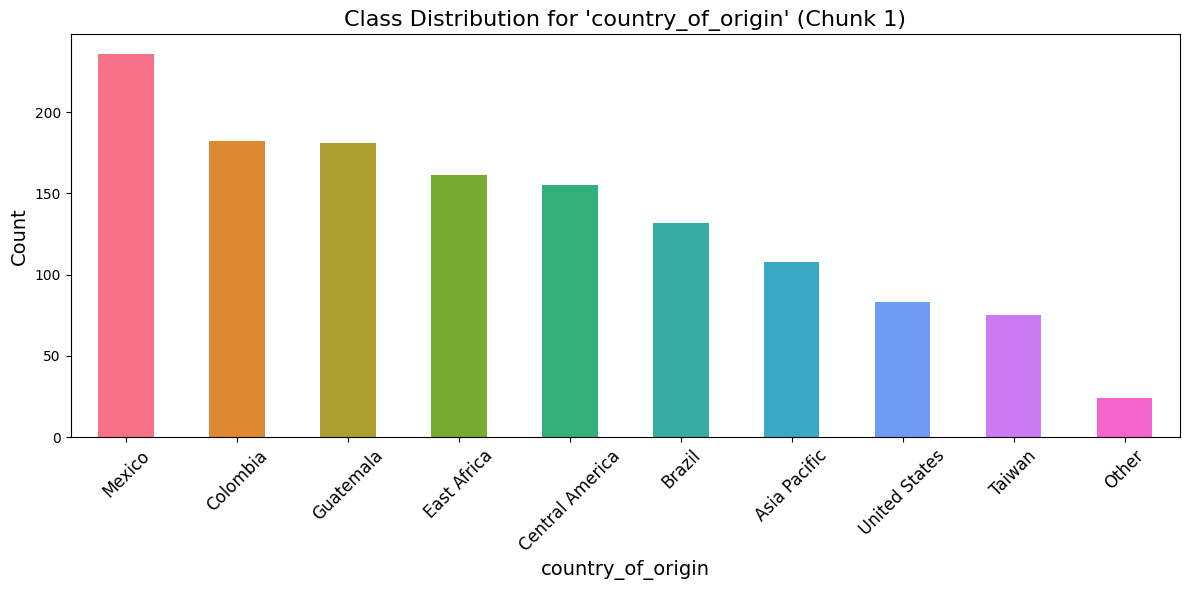

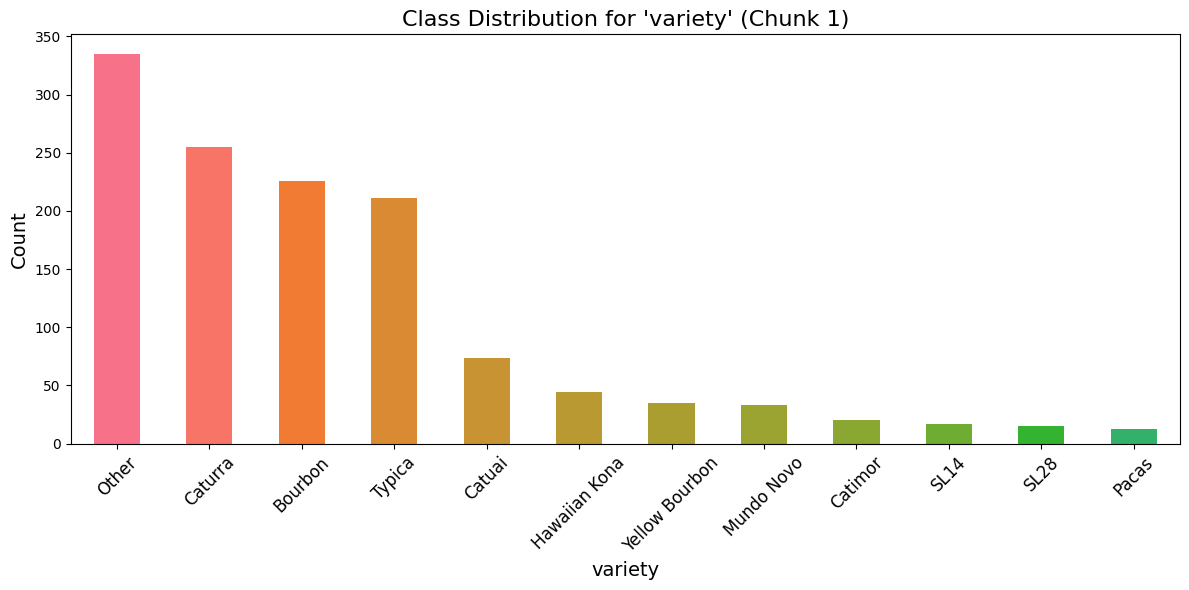

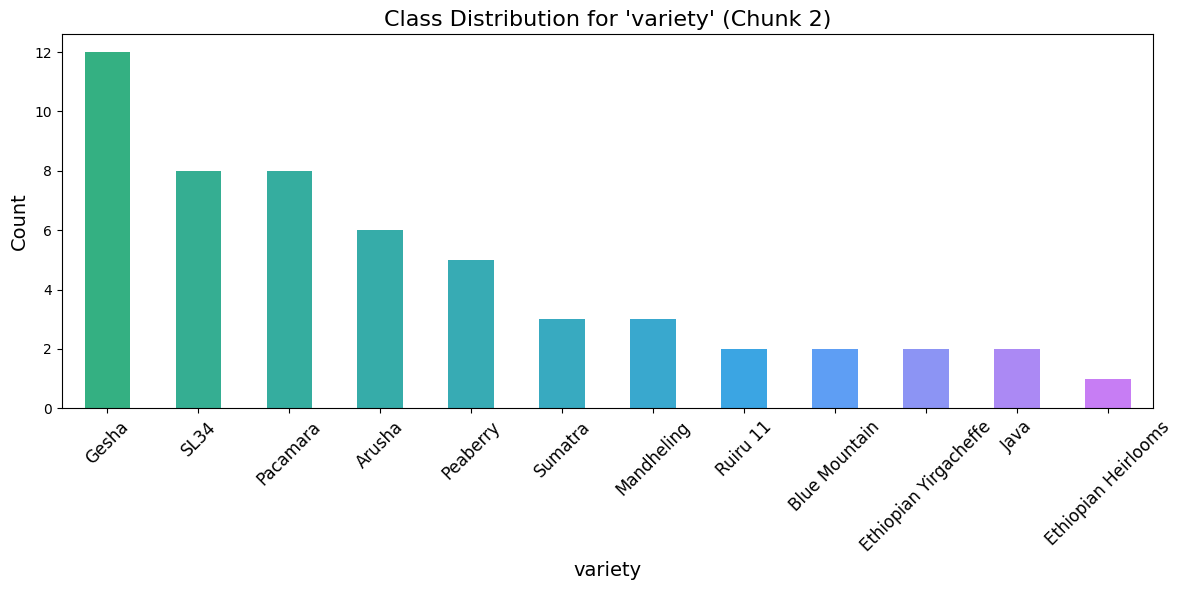

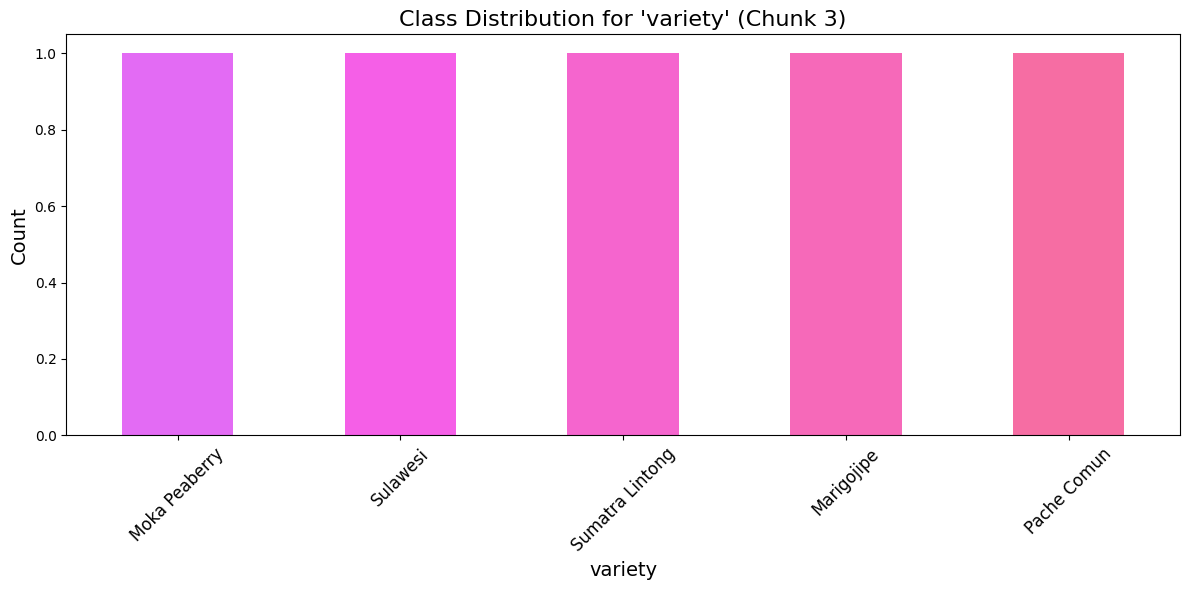

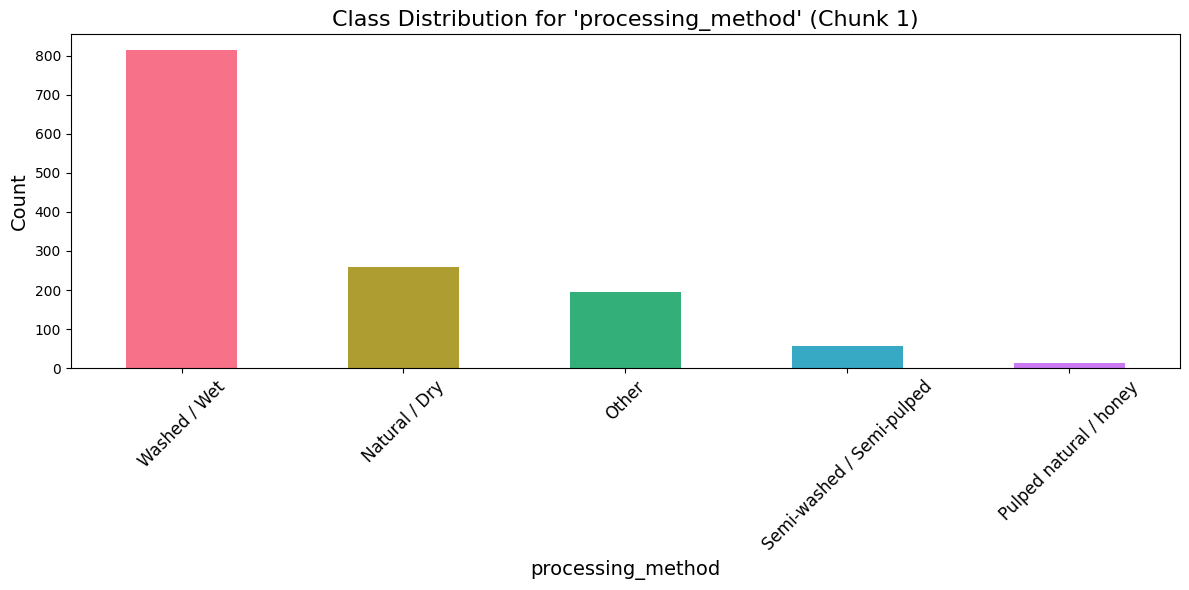

In [27]:
for column in label_cols:
    plot_class_distributions_in_chunks(cleaned_df, column, chunk_size=12)

## Save the original and augmented datasets as CSV files
Write the cleaned dataframe into a CSV file dataset

In [28]:
dataset_path = 'datasets/preprocessed_coffee_data.csv'
cleaned_df.to_csv(dataset_path, index=False, encoding='utf-8')
print(f"Successfully saved original dataset to {dataset_path}")

Successfully saved original dataset to datasets/preprocessed_coffee_data.csv
